# Train an Agent using  Adversarial Inverse Reinforcement Learning


As usual, we first need an expert. 
Note that we now use a variant of the CartPole environment from the seals package, which has fixed episode durations. Read more about why we do this [here](https://imitation.readthedocs.io/en/latest/guide/variable_horizon.html).

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
import gym
import seals

env = gym.make("seals/CartPole-v0")
expert = PPO(
            policy=MlpPolicy,
            env=env,
            seed=0,
            batch_size=64,
            ent_coef=0.0,
            learning_rate=0.0003,
            n_epochs=10,
            n_steps=64,
        )
expert.learn(100000)

We generate some expert trajectories, that the discriminator needs to distinguish from the learners trajectories.

In [ ]:
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import DummyVecEnv

rollouts = rollout.rollout(
        expert,
        DummyVecEnv([lambda: RolloutInfoWrapper(gym.make("seals/CartPole-v0"))] * 5),
        rollout.make_sample_until(min_timesteps=None, min_episodes=60),
    )

Now we are ready to set up our gail trainer.
Note, that the `reward_net` is actually the network of the discriminator.
We evaluate the learner before and after training so we can see if it made any progress.

In [ ]:
from imitation.algorithms.adversarial.airl import AIRL
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

import gym
import seals


venv = DummyVecEnv([lambda : gym.make("seals/CartPole-v0")] * 8)
learner = PPO(env = venv, policy=MlpPolicy, batch_size=64, ent_coef=0.0, learning_rate=0.0003, n_epochs=10)
reward_net = BasicRewardNet(venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm)
gail_trainer = AIRL(
    demonstrations=rollouts, 
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round = 4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net
    )

learner_rewards_before_training, _ = evaluate_policy(learner, venv, 100, return_episode_rewards=True)
gail_trainer.train(300000)
learner_rewards_after_training, _ = evaluate_policy(learner, venv, 100, return_episode_rewards=True)


When we look at the histograms of rewards before and after learning, we can see that the learner is not perfect yet, but it made some progress at least.
If not, just re-run the above cell.

128.47
42.14


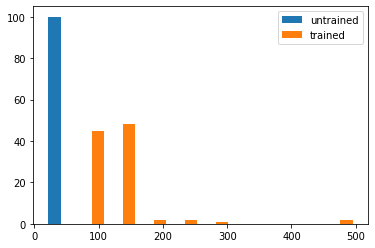

In [7]:
import matplotlib.pyplot as plt
import numpy as np

print(np.mean(learner_rewards_after_training))
print(np.mean(learner_rewards_before_training))

plt.hist(
    [learner_rewards_before_training, learner_rewards_after_training], 
    label=["untrained", "trained"])
plt.legend()
plt.show()